In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import torchaudio
import subprocess
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from glob import glob as glob_file
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from fastai.vision.all import *
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor

from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, OneOf, Normalize, Resize,
    Flip, HorizontalFlip, VerticalFlip, CenterCrop, RandomResizedCrop,
    Rotate, ShiftScaleRotate, RandomRotate90, Transpose,
    RGBShift, ChannelShuffle, HueSaturationValue, RandomBrightnessContrast,
    Blur, MotionBlur, MedianBlur, GaussNoise, Cutout, CoarseDropout
)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
# timm.list_models(pretrained=True)

In [4]:
CFG = {
    "save_prev"     : [True, ["*.pth"]],
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "base_path"     : "../input/birdclef-2022/",
    "img_path"      : "../input/birdclef-spectrograms-fulldataset/",
    "output_path"   : './',
    "n_sample_train": 200,
    "n_sample_test" : 80,
    "pretrain"      : None,
    "save_name"     : "birdclef_effnet_wav2vec",
    "model"         : "tf_efficientnet_b5_ns",
    "size"          : 456,
    "valid_pct"     : 0.3,
    "batch_size"    : 8,
    "epochs"        : 5,
    "n_data"        : None,  # Batch * step
    "lr"            : 1e-4,
    "early_stopping": 3,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['*.pth']],
 'seed': 42,
 'device': 'cuda:0',
 'base_path': '../input/birdclef-2022/',
 'img_path': '../input/birdclef-spectrograms-fulldataset/',
 'output_path': './',
 'n_sample_train': 200,
 'n_sample_test': 80,
 'pretrain': None,
 'save_name': 'birdclef_effnet_wav2vec',
 'model': 'tf_efficientnet_b5_ns',
 'size': 456,
 'valid_pct': 0.3,
 'batch_size': 8,
 'epochs': 5,
 'n_data': None,
 'lr': 0.0001,
 'early_stopping': 3,
 'num_workers': 4}

In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [6]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob_file(f"../input/birdclef-models/{file_pattern}"):
            filename = os.path.basename(f)
            print(filename)
            !cp {f} ./{filename}

birdclef_swin_wav2vec.pth


# Load data

10269 4
puaioh
crehon
10269 18
(127, 3)


[18, 20, 20, 21, 28, 32, 34, 43, 43, 47]

<AxesSubplot:>

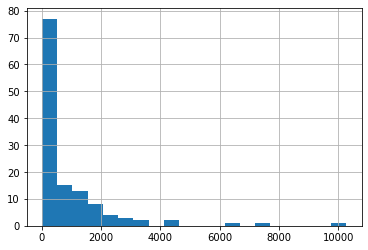

In [7]:
# Scored bird names
scored_birds = pd.read_json(f"{CFG['base_path']}scored_birds.json").values.flatten().tolist()

# No. of files
file_num = []
for d in os.listdir(CFG['img_path']):
    file_num.append([d, len(os.listdir(f"{CFG['img_path']}{d}")), f"{CFG['img_path']}{d}/"])
df_file_num = pd.DataFrame(file_num, columns=["bird", "file_num", "path"])
print(df_file_num.file_num.max(), df_file_num.file_num.min())

del_n = 10
less_birds  = df_file_num[df_file_num.file_num < del_n].bird
for lb in less_birds:
    if lb in scored_birds:
        print(lb)
df_file_num = df_file_num[df_file_num.file_num >= del_n]
df_file_num = df_file_num[~df_file_num.bird.isin(scored_birds)]
df_file_num = df_file_num.sort_values("file_num").reset_index(drop=True)
print(df_file_num.file_num.max(), df_file_num.file_num.min())

print(df_file_num.shape)
display(df_file_num.file_num.to_list()[:10])
df_file_num.file_num.hist(bins=20)

(901, 626, 3)


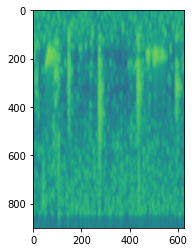

In [8]:
b = 0
n = 0
p = df_file_num.path[b] + os.listdir(df_file_num.path[b])[n]
print(get_img(p).shape)
plt.imshow(get_img(p))

In [9]:
image_paths = []
for label, (b, p) in enumerate(zip(df_file_num.bird, df_file_num.path)):
    train_n = int(len(os.listdir(p))*0.7)
    test_n  = min(len(os.listdir(p)) - train_n, CFG["n_sample_test"])
    #print(df_file_num.bird[label], train_n, test_n)
    all_paths   = os.listdir(p)
    test_paths  = random.sample(all_paths, k=test_n)
    train_paths = [ap for ap in all_paths if ap not in test_paths]
    train_paths = random.choices(train_paths, k=CFG["n_sample_train"])
    
    test_paths  = [[1, pi[:pi.find(".ogg")+4], b, label, p + pi] for pi in test_paths]
    train_paths = [[0, pi[:pi.find(".ogg")+4], b, label, p + pi] for pi in train_paths]
    image_paths += train_paths + test_paths
df_train = pd.DataFrame(image_paths, columns=["is_valid", "filename", "label_name", "label", "img_path"])
df_train["audio_path"] = CFG['base_path'] + "train_audio/" + df_train.label_name + "/" + df_train.filename

print(df_train[df_train.is_valid==0].shape, df_train[df_train.is_valid==1].shape)
df_train.head()

(25400, 6) (7674, 6)


,is_valid,filename,label_name,label,img_path,audio_path
0,0,XC385058.ogg,mauala,0,../input/birdclef-spectrograms-fulldataset/mauala/XC385058.ogg.007.jpg,../input/birdclef-2022/train_audio/mauala/XC385058.ogg
1,0,XC385058.ogg,mauala,0,../input/birdclef-spectrograms-fulldataset/mauala/XC385058.ogg.007.jpg,../input/birdclef-2022/train_audio/mauala/XC385058.ogg
2,0,XC75481.ogg,mauala,0,../input/birdclef-spectrograms-fulldataset/mauala/XC75481.ogg.001.jpg,../input/birdclef-2022/train_audio/mauala/XC75481.ogg
3,0,XC385058.ogg,mauala,0,../input/birdclef-spectrograms-fulldataset/mauala/XC385058.ogg.000.jpg,../input/birdclef-2022/train_audio/mauala/XC385058.ogg
4,0,XC385058.ogg,mauala,0,../input/birdclef-spectrograms-fulldataset/mauala/XC385058.ogg.006.jpg,../input/birdclef-2022/train_audio/mauala/XC385058.ogg


# Define model

In [10]:
class BirdCLEF_Dataset(Dataset):
    
    def __init__(self, df, transforms=None, output_label=True, is_train=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.output_label = output_label
        self.is_train     = is_train
        self.processor    = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img_path = self.df.loc[index].img_path
        img_num  = int(img_path[-7:-4])  # Extract XXX from XXX.jpg
        img      = get_img(img_path).copy()
        waveform, sr = torchaudio.load(self.df.loc[index].audio_path)
        waveform = waveform[0]
        if len(waveform) < sr*5:
            rep      = round(float(sr*5) / len(waveform))
            waveform = waveform.repeat(int(rep)+1)
            waveform = waveform[:sr*5]
        else:
            sta = sr*5*img_num
            end = sr*5*(img_num+1)
            if len(waveform[sta:end]) == sr*5:
                waveform = waveform[sta:end]
            else:
                waveform = waveform[-sr*5:]
        waveform     = self.processor(waveform, sampling_rate=16000, return_tensors="pt").input_values
        y = torch.from_numpy(np.array(self.df.loc[index, "label"]))
        if self.transforms:
            if self.is_train:
                p = np.random.rand(1)
                if p < 0.5:
                    # Horizontal flip
                    img      = img[:, ::-1]
                    waveform = waveform.flip(0)
            img = self.transforms(image=img)['image']
        if self.output_label:
            return img, waveform.reshape(-1), y
        return img, waveform.reshape(-1)
    
def transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)
  
def prepare_dataloader(df, custom):
    df = df.copy()
    if custom:
        train      = df[df.is_valid==0].reset_index(drop=True).copy()
        valid      = df[df.is_valid==1].reset_index(drop=True).copy()
        train_ds   = BirdCLEF_Dataset(train, transforms=transforms())
        valid_ds   = BirdCLEF_Dataset(valid, transforms=transforms(), is_train=False)
        dataloader = DataLoaders.from_dsets(train_ds, valid_ds, bs=CFG['batch_size'])
        if -1 < CFG["device"].find("cuda"):
            dataloader = dataloader.cuda()
    else:
        dataloader = ImageDataLoaders.from_df(
            df,
            valid_col='is_valid',
            seed=CFG["seed"],
            fn_col='img_path',
            label_col="label",
            y_block=CategoryBlock,
            bs=CFG['batch_size'],
            n=CFG["n_data"],
            shuffle=True,
            num_workers=CFG['num_workers'],
            item_tfms=Resize(CFG['size']),
            batch_tfms=setup_aug_tfms([Flip()])
        )
    return dataloader

In [11]:
#dataloader = prepare_dataloader(df_train, True)
#img, waveform, y = dataloader.one_batch()
#waveform.shape

In [12]:
#audio_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cuda")
#audio_model = audio_model.wav2vec2.feature_extractor
#x = audio_model(waveform)
#x.logits.shape

In [13]:
#a = nn.Conv2d(kernel_size=3, stride=2, in_channels=1, out_channels=1)
#d = torch.unsqueeze(b,1)
#a = a(d)
#f = nn.Flatten()
#f(x.logits).shape
#c = nn.Linear(499*32, 120)
#c(a).shape

In [14]:
class ImageAndAudioModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.img_model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        self.audio_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(CFG["device"])
        #self.audio_model = audio_model.wav2vec2.feature_extractor.to("cuda")
        num_features = self.img_model.num_features
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(499*32, 1024)
        self.linear2 = nn.Linear(num_features+1024, df_train.label.max()+1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, w):
        x1 = self.img_model(x)
        x2 = self.audio_model(w).logits
        x2 = self.flatten(x2)
        x2 = self.linear1(x2)
        out = torch.cat((x1, x2), 1)
        out = self.dropout(out)
        out = self.linear2(out)
        return out

def get_learner(df, custom=True):
    dataloader = prepare_dataloader(df, custom)
    if CFG['pretrain'] is None:
        model = ImageAndAudioModel(CFG["model"], pretrained=True)
    else:
        model = ImageAndAudioModel(CFG["model"], pretrained=False)
        model.load_state_dict(torch.load(CFG['pretrain']))
    learner = Learner(
        dataloader,
        model,
        loss_func=CrossEntropyLossFlat(),
        metrics=accuracy).to_fp16()
    return learner

# Train model

In [15]:
all_preds = []

learn = get_learner(df_train, True)
learn.fit_one_cycle(
    CFG["epochs"],
    CFG["lr"],
    cbs=[SaveModelCallback(),
         EarlyStoppingCallback(monitor='valid_loss',
                               comp=np.less,
                               patience=CFG['early_stopping'])]
)

shutil.move("./models/model.pth", f"{CFG['output_path']}{CFG['save_name']}.pth")
!rm -rf ./models

del learn
torch.cuda.empty_cache()
gc.collect()

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,2.945281,2.717913,0.348449,1:48:24
1,1.265619,1.599287,0.611415,1:47:34
2,0.673544,1.338442,0.697941,1:47:56
3,0.320711,1.169255,0.742116,1:48:16
4,0.111604,1.164834,0.751108,1:47:29


Better model found at epoch 0 with valid_loss value: 2.7179131507873535.
Better model found at epoch 1 with valid_loss value: 1.5992871522903442.
Better model found at epoch 2 with valid_loss value: 1.3384424448013306.
Better model found at epoch 3 with valid_loss value: 1.169255018234253.
Better model found at epoch 4 with valid_loss value: 1.164833903312683.


9